# Dataset and base code for PGMC+O
This notebook contains all the necessary code to load the dataset and an implementation of PGMC+O.

## 1. Imports

In [1]:
# Maths and data management
import math
from math import pi
import numpy as np
import scipy as sp
import pandas as pd
import pickle
import time
from tqdm import tqdm

In [2]:
# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting configuration
%matplotlib inline
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
# ML toolkit
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

# Powell
from scipy.optimize import minimize

from multiprocessing import Pool

# 2. Implementation of PGMC/PGMC+O
This section contains the implementation for the PGMC and PGMC+O. The two classes work just like any other sklearn classifier with a fit and predict functions. 

## 2.1 Basic tools

In [4]:
def tensor_power(mat,n):
    """
    Tensorial power of a marix.
    """
    assert(int(n)==n)
    assert(n>=0)
    ret = np.array([[1]])
    for i in range(n):
        ret = np.kron(ret,mat)
    return ret

def metrics(y_true,y_pred,average="binary",silent=False):
    """
    Compute and return a lot of metrics given prediction and ground truths.
    """
    if len(list(set(y_pred))) > 2 and average == "binary":
        average = "micro"
    accuracy = sk.metrics.accuracy_score(y_true,y_pred)
    precision = sk.metrics.precision_score(y_true,y_pred,average=average,zero_division=0)
    recall = sk.metrics.recall_score(y_true,y_pred,average=average,zero_division=0)
    ba = sk.metrics.balanced_accuracy_score(y_true, y_pred)
    mse = sk.metrics.mean_squared_error(y_true, y_pred)
    confusion = sk.metrics.confusion_matrix(y_true,y_pred)
    fmeas = sk.metrics.f1_score(y_true,y_pred,average=average,zero_division=0)
    if not silent:
        print("Accuracy : ",accuracy)
        print("Precision : ",precision)
        print("Recall : ",recall)
        print("BA : ",ba)
        print("MSE : ",mse)
        print("F-measure : ",fmeas)
        print("Confusion matrix : \n",confusion)
    return [accuracy,precision,recall,ba,mse,fmeas,confusion]


def imbalance(X,y,ratio):
    """
    Articificially imbalance a dataset.
    """
    X0 = np.array([[X[i],y[i]] for i in range(len(y)) if y[i] == 0],dtype=object)
    X1 = np.array([[X[i],y[i]] for i in range(len(y)) if y[i] == 1],dtype=object)
    current = len(X1)/(len(X0)+len(X1))
    if current > ratio:
        desired_len = int(len(X0)*ratio/(1-ratio))
        c1 = np.random.choice(list(range(len(X1))),desired_len,replace=False)
        X1 = X1[c1]
    else:
        desired_len = int(len(X1)*(1-ratio)/ratio)
        c0 = np.random.choice(list(range(len(X0))),desired_len,replace=False)
        X0 = X0[c0]
    data = np.concatenate([X0,X1])
    X_ = np.array(list(data[:,0]))
    y_ = np.array(list(data[:,1]))
    return X_,y_

The three imbeddings introduced in the paper.

In [5]:
def normalize(x):
    """
    Amplitude embedding or simply a normalization.
    """
    return x/np.linalg.norm(x)

def stereo(x):
    """
    Inverse stereoscopic projection embedding.
    """
    return np.append(2*x/(np.linalg.norm(x)**2+1), (np.linalg.norm(x)**2-1)/(np.linalg.norm(x)**2+1))

def orthogonalize(x):
    """
    Orthogonal embedding (one of our contribution in the paper).
    """
    u = normalize(x)
    u = np.append(u,1.)
    return normalize(u)

## 2.2 Implementation of PGMC

In [6]:
class PGMC:
    def __init__(self,copies=1,proportion=[],embedding="normal"):
        """
        Class for the PGMC classifier.
            - copies : number of copies in the PGM (refer to the paper for further details).
            - proportion : specify the meta-parameter which is the proportions in the PGM.
            - embedding : specify the embedding ... can be either "normal" for an amplitude embedding, "ISP" for inverse stereoscopic embedding or "ortho" for orthogonal embedding. 
        """
        self.E = []
        self.copies=copies
        self.proportion=proportion
        self.embedding = embedding
        self.ampl = 0.

    def PGM(self,p,rho):
        rho = [tensor_power(i,self.copies) for i in rho]
        r = sum([p[k]*rho[k].copy() for k in range(len(p))])
        r = sp.linalg.sqrtm(np.linalg.pinv(r))
        E = [np.linalg.multi_dot([r,p[k]*rho[k],r]) for k in range(len(p))]
        return E 
    
    def convert_vector(self,x):
        if self.embedding == "ISP":
            u = stereo(x)
        elif self.embedding == "ortho":
            u = orthogonalize(x)
        else:
            u = normalize(x)
        u = u.reshape(len(u),1)
        rho = u.dot(u.transpose())
        return rho

    def fit(self,X,y):
        """
        Given a dataset X and ground truth y, train the PGMC for a classification task.
        """
        self.K = list(map(int,list(set(y))))
        X = [self.convert_vector(x) for x in X]
        rho = []
        p = []
        for k in self.K:
            tmp = [X[i] for i in range(len(X)) if y[i]==k]
            rho.append(sum(tmp)/len(tmp))
            p.append(len(tmp))
        if len(self.proportion) == len(self.K):
            p = self.proportion
        p = np.array(p)/sum(p)
        self.E = self.PGM(p,rho)
        
    def predict_one(self,x):
        rho = tensor_power(self.convert_vector(x),self.copies)
        return np.array([np.trace(np.dot(self.E[k],rho)) for k in self.K])
        
    def predict_distribution(self,X):
        distrib = [self.predict_one(x) for x in X]
        return distrib
    
    def predict(self,X):
        """
        Given a dataset X, try to predict the corresponding class.
        """
        distrib = self.predict_distribution(X)
        ret = []
        for d in distrib:
            ret.append(max(list(range(len(d))),key=lambda x:d[x]))
        return np.array(ret)

## 2.3 Implementation of PGMC+O

In [7]:
class PGMO:
    def __init__(self,copies=1,metric=sk.metrics.f1_score,embedding="normal"):
        """
        Class for the PGMC+O classifier.
            - copies : number of copies in the PGM (refer to the paper for further details).
            - metric : the metric we use to optimize de proportion.
            - embedding : specify the embedding ... can be either "normal" for an amplitude embedding, "ISP" for inverse stereoscopic embedding or "ortho" for orthogonal embedding. 
        """
        self.pgmc = None
        self.p = np.array([])
        self.copies=copies
        self.metric = metric
        self.embedding = embedding

    def fit(self,X,y):
        """
        Given a dataset X and ground truth y, train the PGMC+O for a classification task.
        """
        p = np.array([len([1 for j in y if j==i]) for i in set(y)])
        p = p/sum(p)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        X_train, X_test, y_train, y_test = X,X,y,y
        def f_(x):
            p_ = np.array(x)/sum(x)
            pgmc = PGMC(self.copies,p_,embedding=self.embedding)
            pgmc.fit(X_train,y_train)
            return 1.-self.metric(y_test,pgmc.predict(X_test),average="binary" if len(set(y))==2 else "micro")
        K = len(set(y))
        res = minimize(f_,p,bounds=[(0,1) for i in range(K)],method="Powell")
        if f_(p) < res.fun:
            self.p = p
        else:
            self.p = res.x
        self.pgmc = PGMC(self.copies,self.p,embedding=self.embedding)
        self.pgmc.fit(X,y)

    def predict(self,X):
        """
        Given a dataset X, try to predict the corresponding class.
        """
        return self.pgmc.predict(X)

# 3. Datasets
The dataset are mostly stored in pickle format (.pkl extension) excepted for iris which is loaded from sklearn. In this section the functions used to load and preprocess the datasets are presented.

## 3.1 Iris 

/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


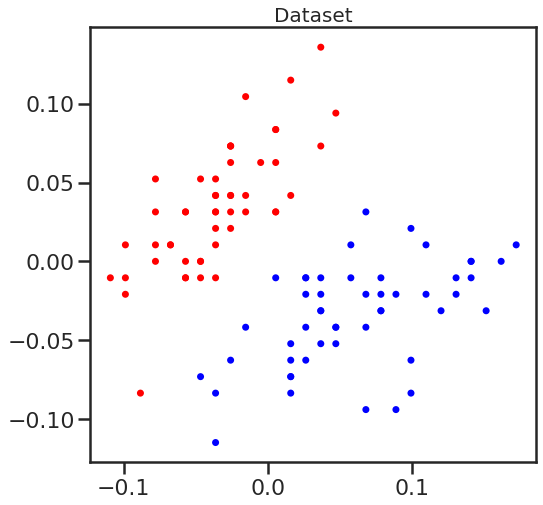

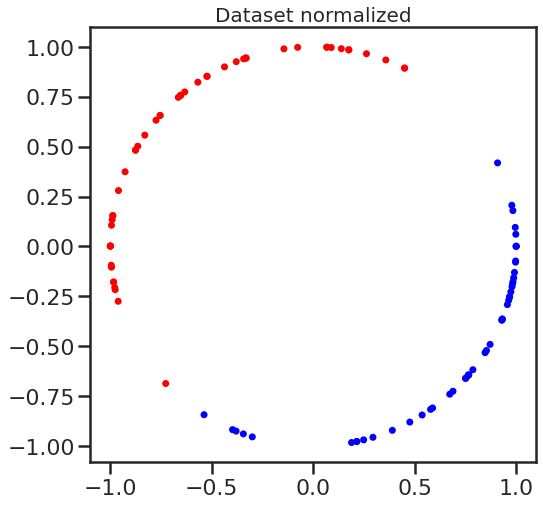

/usr/lib/python3/dist-packages/matplotlib/collections.py:566: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(self.convert_xunits(offsets[:, 0]), 'float'),
/usr/lib/python3/dist-packages/matplotlib/collections.py:567: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asarray(self.convert_yunits(offsets[:, 1]), 'float')))
/usr/lib/python3/dist-packages/matplotlib/colors.py:277: ComplexWarning: Casting complex values to real discards the imaginary part
  c = tuple(map(float, c))


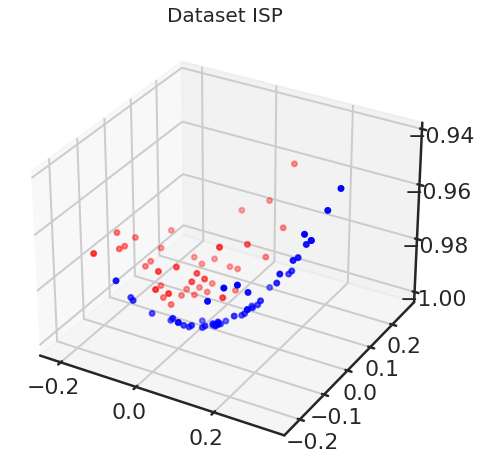

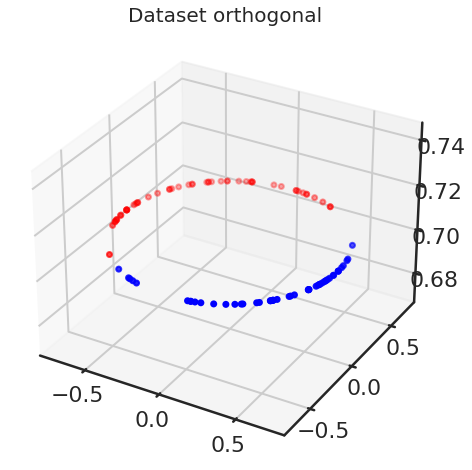

In [8]:
def get_iris():
    """
    Load Iris with some restrictions.
    """
    iris = datasets.load_iris()
    X_ = iris.data[:,:2]
    Y_ = iris.target
    X = np.array([X_[i]+np.array([0,3.3]) for i in range(len(X_)) if Y_[i] != 2])
    y = np.array([1 if i==0 else 0 for i in Y_ if i != 2])
    size_max = max([np.sqrt(sum(x**2)) for x in X])
    X = np.array([[i/size_max for i in x] for x in X],dtype=complex)
    
    u = sum(X)/len(X)
    X = X-u + np.array([0.013,0.])
    return X,y


X,y = get_iris()
plt.figure(figsize=(8,8))
plt.title("Dataset", fontsize='small')
plt.scatter(X[:, 0], X[:, 1], marker='o', color=["red" if i==1 else "blue" for i in y], s=25)

X,y = get_iris()
X = np.array([normalize(x) for x in X])
fig = plt.figure(figsize=(8,8))
plt.title("Dataset normalized", fontsize='small')
plt.scatter(X[:, 0], X[:, 1], marker='o', color=["red" if i==1 else "blue" for i in y], s=25)

X,y = get_iris()
X = np.array([stereo(x) for x in X])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title("Dataset ISP", fontsize='small')
ax.scatter(X[:, 0], X[:, 1], X[:,2], marker='o', color=["red" if i==1 else "blue" for i in y],
            s=25)

X,y = get_iris()
X = np.array([orthogonalize(x) for x in X])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title("Dataset orthogonal", fontsize='small')
ax.scatter(X[:, 0], X[:, 1], X[:,2], marker='o', color=["red" if i==1 else "blue" for i in y],
            s=25)

## 3.2 MNIST

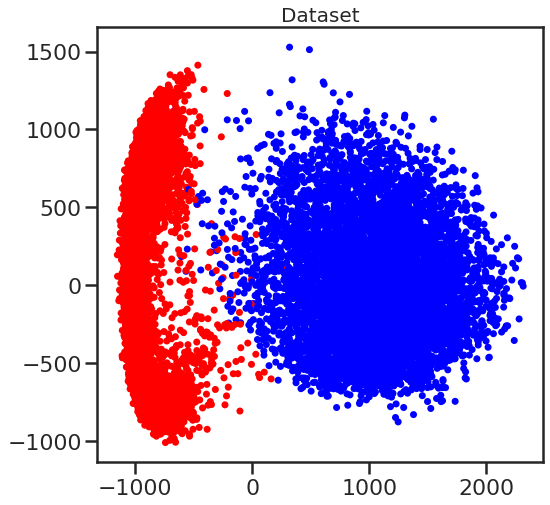

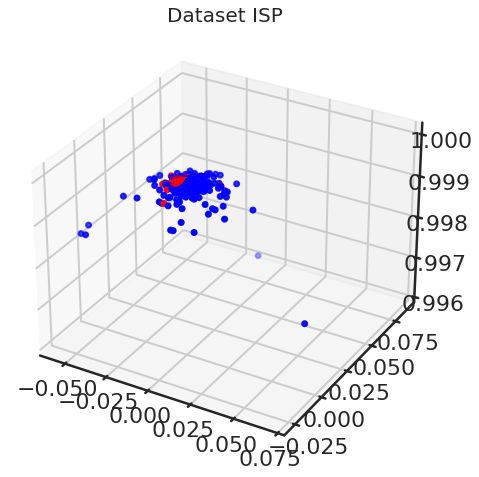

In [9]:
def get_mnist(features=5, nb_classes=2, path="mnist.pkl"):
    """
    Load MNIST, eliminate some classes and apply pca.
    """
    pca = PCA(n_components=features)
    (X,y) = pickle.load(open(path,"rb"))
    X = np.array([X[i] for i in range(len(X)) if y[i] in list(range(nb_classes))])
    y = np.array([y[i] for i in range(len(y)) if y[i] in list(range(nb_classes))])
    if len(X[0]) > features:
        X = pca.fit_transform(X)
    return X,y

X,y = get_mnist(2,2)
plt.figure(figsize=(8,8))
plt.title("Dataset", fontsize='small')
plt.scatter(X[:, 0], X[:, 1], marker='o', color=["red" if i==1 else "blue" for i in y], s=25)

X,y = get_mnist(2,2)
X = np.array([stereo(x) for x in X])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title("Dataset ISP", fontsize='small')
ax.scatter(X[:, 0], X[:, 1], X[:,2], marker='o', color=["red" if i==1 else "blue" for i in y],
            s=25)

## 3.3 MNIST 1D

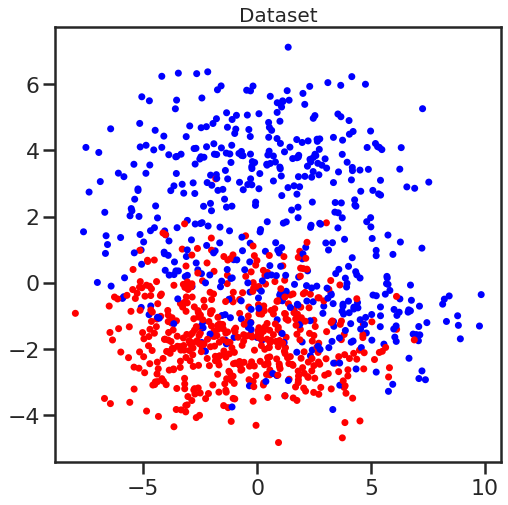

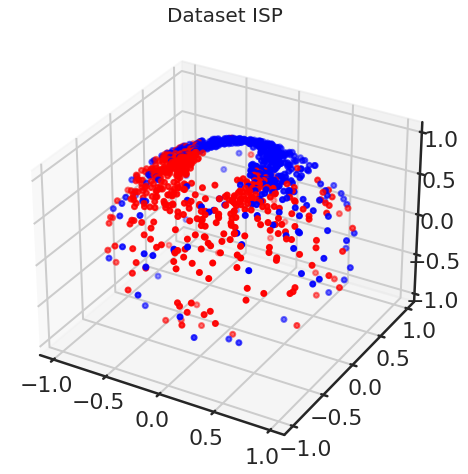

In [10]:
X,y = get_mnist(2,2,path="mnist1d.pkl")
plt.figure(figsize=(8,8))
plt.title("Dataset", fontsize='small')
plt.scatter(X[:, 0], X[:, 1], marker='o', color=["red" if i==1 else "blue" for i in y], s=25)

X,y = get_mnist(2,2,path="mnist1d.pkl")
X = np.array([stereo(x) for x in X])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title("Dataset ISP", fontsize='small')
ax.scatter(X[:, 0], X[:, 1], X[:,2], marker='o', color=["red" if i==1 else "blue" for i in y],
            s=25)

# 4. Classification
This part focus on generating the data used for the figures of the articles. By default nothing will be computed and precomputed data will be udes instead. Change the variable below to True if you want to compute again everything.

A separated section will plot the results.

In [11]:
compute_data = False # Put it to True of you don't want to use saved data for the plots.

# 4.1 Data for the proportion
Here we investigate when the optimization of the proportion matters.

In [12]:
if compute_data:
    X,y = get_mnist(5,2,path="mnist.pkl")
    X = X[::10]
    y = y[::10]

    def find_optimal_proportion(r):
        X_,y_ = imbalance(X,y,r)
        clf = PGMO(1,embedding="ortho")
        clf.fit(X_,y_)
        y_pred = clf.predict(X)
        fmeas = sk.metrics.f1_score(y,y_pred)

        clf2 = PGMC(1,embedding="ortho")
        clf2.fit(X_,y_)
        y_pred2 = clf2.predict(X)
        benchmark = sk.metrics.f1_score(y,y_pred2)

        p = sum(y_)/len(y_)
        return [len(X_),len(X_[0]),p,clf.p[1],fmeas,benchmark]

    data1 = pd.DataFrame()
    args = list(np.linspace(0.01,0.99,20))*100
    print("MNIST")
    with Pool(16) as pool:
        l = np.array(list(tqdm(pool.imap(find_optimal_proportion,args),total=len(args),ncols=50)),dtype=object)
    data1 = pd.concat([data1,pd.DataFrame(l,columns=["size","features","p_data","p_fit","f1-score","benchmark"])])
    data1["dataset"] = ["MNIST"]*len(data1)
    
    X,y = get_mnist(5,2,path="mnist1d.pkl")
    data2 = pd.DataFrame()
    print("MNIST-1D")
    with Pool(16) as pool:
        l = np.array(list(tqdm(pool.imap(find_optimal_proportion,args),total=len(args),ncols=50)),dtype=object)
    data2 = pd.concat([data2,pd.DataFrame(l,columns=["size","features","p_data","p_fit","f1-score","benchmark"])])
    data2["dataset"] = ["MNIST-1D"]*len(data2)
    
    data_pr = pd.concat([data1,data2]).reset_index()
else:
    data_pr = pickle.load(open("data_pr.pkl","rb"))

## 4.2 Main data
Here we run the classification with several classifiers on several datasets.

In [13]:
if compute_data:
    def add_test_aux(arg):
        clf,X,y,name_clf,name_data = arg
        X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)
        T = time.time()
        c = clf
        c.fit(np.array(X_train.real,dtype=float),y_train)
        T = time.time() - T
        y_pred = c.predict(np.array(X_test.real,dtype=float))
        l = metrics(y_test,y_pred,silent=True,average="binary" if len(set(y_test))==2 else "micro")
        return [len(y_train),len(X_train[0])]+l[0:6]+[T,name_clf,name_data]

    def add_test(clf,X,y,name_clf="SVM",name_data="MNIST",repeat=10):
        global data
        args = [(clf(),X,y,name_clf,name_data) for i in range(repeat)]
        with Pool(16) as pool:
            l = np.array(list(pool.imap(add_test_aux,args)),dtype=object)
        data = pd.concat([data,pd.DataFrame(l,columns=["size","features","acc","precision","recall","ba","mse","f1","time","clf","data"])])
        return data
    
    todo = []
    todo = [(get_iris())]
    data_name = ["Iris"]

    for i in range(10):
        X,y = get_mnist(50,2,path="mnist.pkl") # i features 2 classes
        X,y = X[::20],y[::20]
        todo.append((X,y))
        data_name.append("MNIST 0.5|0.5")
        X,y = get_mnist(50,2,path="mnist.pkl") # i features 2 classes
        X,y = X[::20],y[::20]
        todo.append(imbalance(X,y,0.1))
        data_name.append("MNIST 0.9|0.1")

    for i in range(10):
        X,y = get_mnist(40,2,path="mnist1d.pkl") # i features 2 classes
        todo.append((X,y))
        data_name.append("MNIST-1D 0.5|0.5")
        X,y = get_mnist(40,2,path="mnist1d.pkl") # i features 2 classes
        todo.append(imbalance(X,y,0.1))
        data_name.append("MNIST-1D 0.9|0.1")


    data = pd.DataFrame()

    repeat=1

    for i in tqdm(range(len(todo))):
        X,y = todo[i]
        add_test(lambda :SVC(),X,y,"SVM",data_name[i],repeat=repeat)
        add_test(lambda :DecisionTreeClassifier(),X,y,"Tree",data_name[i],repeat=repeat)
        add_test(lambda :PGMC(1,embedding="normal"),X,y,"PGMC normal",data_name[i],repeat=repeat)
        #add_test(lambda :PGMC(1,embedding="ISP"),X,y,"PGMC ISP",data_name[i],repeat=repeat)
        add_test(lambda :PGMC(1,embedding="ortho"),X,y,"PGMC ortho",data_name[i],repeat=repeat)
        add_test(lambda :PGMO(1,embedding="normal"),X,y,"PGMO normal",data_name[i],repeat=repeat)
        #add_test(lambda :PGMO(1,embedding="ISP"),X,y,"PGMO ISP",data_name[i],repeat=repeat)
        add_test(lambda :PGMO(1,embedding="ortho"),X,y,"PGMO ortho",data_name[i],repeat=repeat)

    data = data.reset_index()
else:
    data = pickle.load(open("data.pkl","rb"))

# 5. Results
In this section we plot the results of the simulations from before.

## 5.1 Embedding
This section plot comparisons of several embeddings for the PGM-C classifier. It mainly shows that the orthogonal embedding we propose seems to perform better and wit more stability than normalization or ISP.

In [14]:
data.groupby(["data","clf"]).mean(numeric_only=False)

index   size  features       acc  precision  \
data             clf                                                        
Iris             PGMC normal    0.0   80.0       2.0  0.550000   0.500000   
                 PGMC ortho     0.0   80.0       2.0  1.000000   1.000000   
                 PGMO normal    0.0   80.0       2.0  0.450000   0.450000   
                 PGMO ortho     0.0   80.0       2.0  1.000000   1.000000   
                 SVM            0.0   80.0       2.0  1.000000   1.000000   
                 Tree           0.0   80.0       2.0  0.900000   0.888889   
MNIST 0.5|0.5    PGMC normal    0.0  591.0      50.0  0.993243   0.986301   
                 PGMC ortho     0.0  591.0      50.0  1.000000   1.000000   
                 PGMO normal    0.0  591.0      50.0  1.000000   1.000000   
                 PGMO ortho     0.0  591.0      50.0  1.000000   1.000000   
                 SVM            0.0  591.0      50.0  1.000000   1.000000   
                 Tree           0.0  591.0      50.0  0.993243   0.986301   
MNIST 0.9|0.1    PGMC normal    0.0  316.0      50.0  0.883544   1.000000   
                 PGMC ortho     0.0  316.0      50.0  0.997468   1.000000   
                 PGMO normal    0.0  316.0      50.0  0.994937   1.000000   
                 PGMO ortho     0.0  316.0      50.0  1.000000   1.000000   
                 SVM            0.0  316.0      50.0  0.998734   1.000000   
                 Tree           0.0  316.0      50.0  0.998734   1.000000   
MNIST-1D 0.5|0.5 PGMC normal    0.0  800.0      40.0  0.895000   0.852941   
                 PGMC ortho     0.0  800.0      40.0  0.955000   0.977273   
                 PGMO normal    0.0  800.0      40.0  0.910000   0.894737   
                 PGMO ortho     0.0  800.0      40.0  0.955000   0.946809   
                 SVM            0.0  800.0      40.0  0.990000   0.989247   
                 Tree           0.0  800.0      40.0  0.960000   0.977528   
MNIST-1D 0.9|0.1 PGMC normal    0.0  444.0      40.0  0.891892   0.000000   
                 PGMC ortho     0.0  444.0      40.0  0.891892   0.000000   
                 PGMO normal    0.0  444.0      40.0  0.933333   0.950000   
                 PGMO ortho     0.0  444.0      40.0  0.976577   0.974615   
                 SVM            0.0  444.0      40.0  0.991892   1.000000   
                 Tree           0.0  444.0      40.0  0.918018   0.631425   

                                recall        ba       mse        f1      time  
data             clf                                                            
Iris             PGMC normal  0.666667  0.560606  0.450000  0.571429  0.001588  
                 PGMC ortho   1.000000  1.000000  0.000000  1.000000  0.002218  
                 PGMO normal  1.000000  0.500000  0.550000  0.620690  0.331943  
                 PGMO ortho   1.000000  1.000000  0.000000  1.000000  0.357790  
                 SVM          1.000000  1.000000  0.000000  1.000000  0.000986  
                 Tree         0.888889  0.898990  0.100000  0.888889  0.000852  
MNIST 0.5|0.5    PGMC normal  1.000000  0.993421  0.006757  0.993103  0.014467  
                 PGMC ortho   1.000000  1.000000  0.000000  1.000000  0.019036  
                 PGMO normal  1.000000  1.000000  0.000000  1.000000  6.410846  
                 PGMO ortho   1.000000  1.000000  0.000000  1.000000  4.333252  
                 SVM          1.000000  1.000000  0.000000  1.000000  0.003095  
                 Tree         1.000000  0.993421  0.006757  0.993103  0.003921  
MNIST 0.9|0.1    PGMC normal  0.233333  0.616667  0.116456  0.363355  0.010516  
                 PGMC ortho   0.983333  0.991667  0.002532  0.991304  0.011549  
                 PGMO normal  0.966667  0.983333  0.005063  0.982609  3.849322  
                 PGMO ortho   1.000000  1.000000  0.000000  1.000000  2.865325  
                 SVM          0.991667  0.995833  0.001266  0.995652  0.001705  
                 Tree     

/tmp/ipykernel_211342/3659354694.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=data[data.clf!="PGMO normal"][data.clf!="PGMO ortho"][data.clf!="PGMO ISP"], x="data",y="f1", hue="clf")


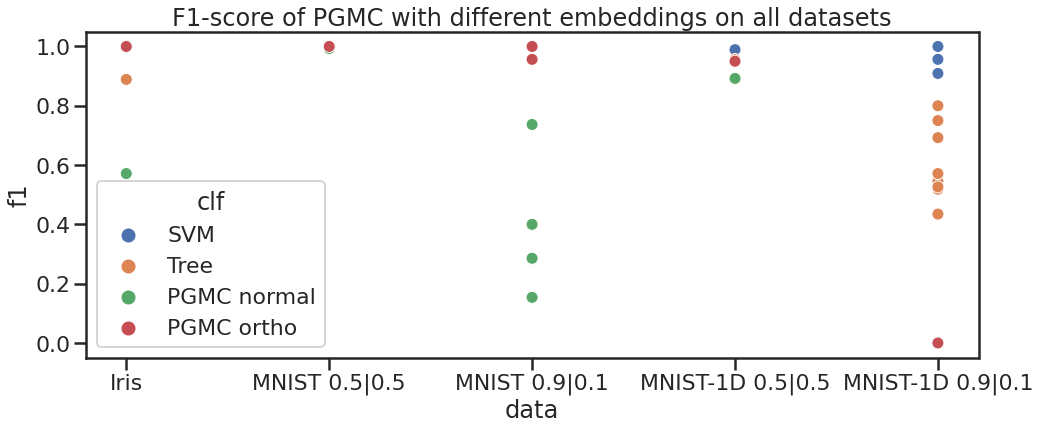

In [15]:
plt.figure(figsize=(16,6))
plt.title("F1-score of PGMC with different embeddings on all datasets")
sns.scatterplot(data=data[data.clf!="PGMO normal"][data.clf!="PGMO ortho"][data.clf!="PGMO ISP"], x="data",y="f1", hue="clf")
plt.savefig("preprocess_all.png")

## 5.2 Optimization of the proportion
In this section we show that the optimization of the proportion can lead to significant improvements, especially for imbalanced datasets.

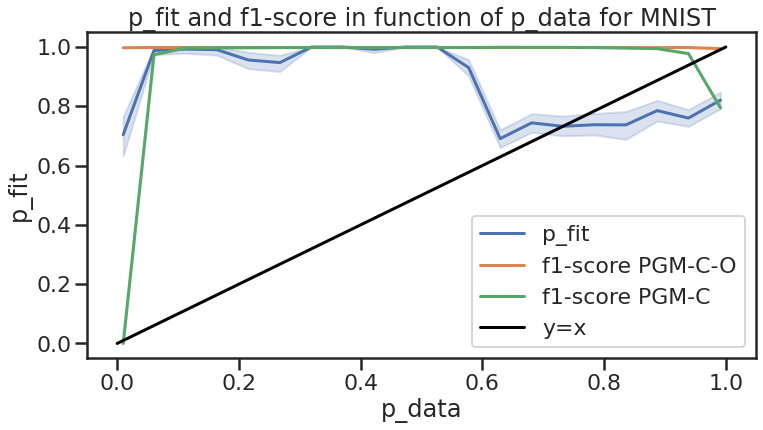

In [16]:
plt.figure(figsize=(12,6))
plt.title("p_fit and f1-score in function of p_data for MNIST")
sns.lineplot(data=data_pr[data_pr.dataset=="MNIST"],x="p_data",y="p_fit",label="p_fit")
sns.lineplot(data=data_pr[data_pr.dataset=="MNIST"],x="p_data",y="f1-score",label="f1-score PGM-C-O")
sns.lineplot(data=data_pr[data_pr.dataset=="MNIST"],x="p_data",y="benchmark",label="f1-score PGM-C")
x = np.linspace(0,1,100)
plt.plot(x,x,label="y=x",color="black")
plt.legend()
plt.savefig("p_fit_MNIST.png")

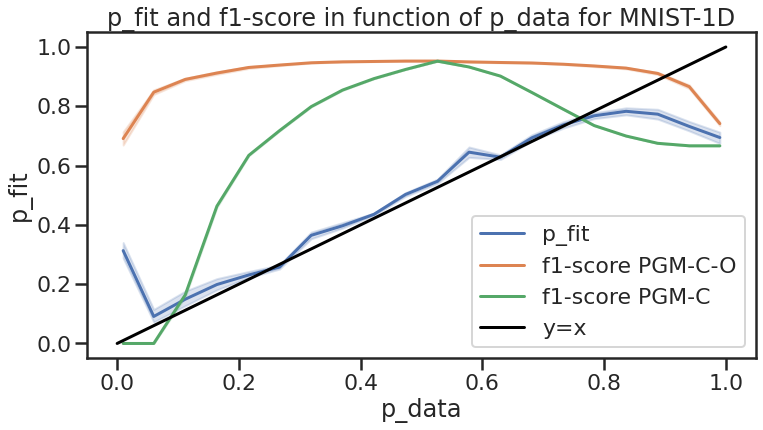

In [17]:
plt.figure(figsize=(12,6))
plt.title("p_fit and f1-score in function of p_data for MNIST-1D")
sns.lineplot(data=data_pr[data_pr.dataset=="MNIST-1D"],x="p_data",y="p_fit",label="p_fit")
sns.lineplot(data=data_pr[data_pr.dataset=="MNIST-1D"],x="p_data",y="f1-score",label="f1-score PGM-C-O")
sns.lineplot(data=data_pr[data_pr.dataset=="MNIST-1D"],x="p_data",y="benchmark",label="f1-score PGM-C")
x = np.linspace(0,1,100)
plt.plot(x,x,label="y=x",color="black")
plt.legend()
plt.savefig("p_fit_MNIST1D.png")

## 5.3 Overall results

<AxesSubplot:title={'center':'Accuracy on MNIST balanced'}, xlabel='clf', ylabel='acc'>

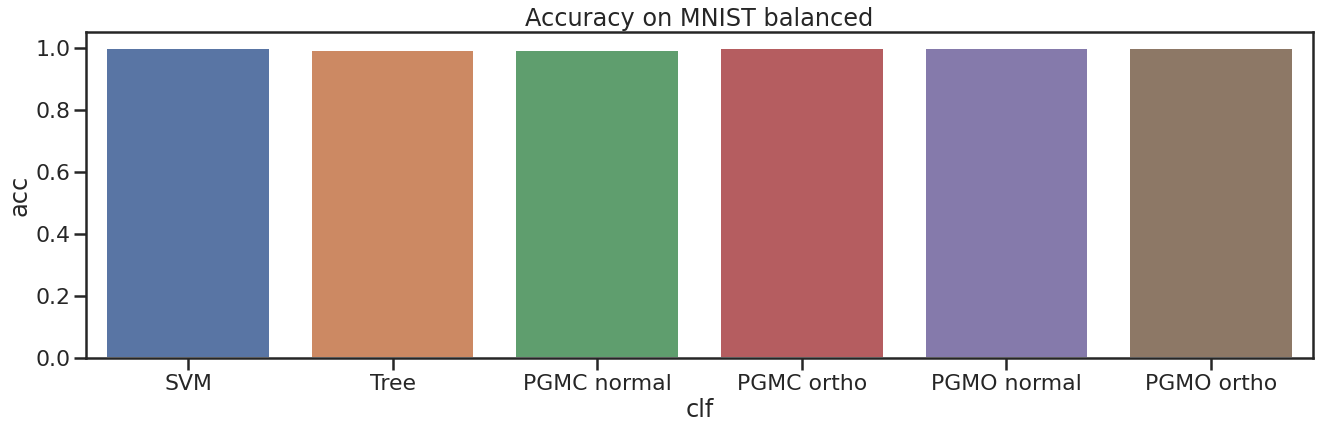

In [18]:
plt.figure(figsize=(22,6))
plt.title("Accuracy on MNIST balanced")
sns.barplot(data=data[data.data=="MNIST 0.5|0.5"],x="clf",y="acc")

<AxesSubplot:title={'center':'Accuracy on MNIST-1D balanced'}, xlabel='clf', ylabel='acc'>

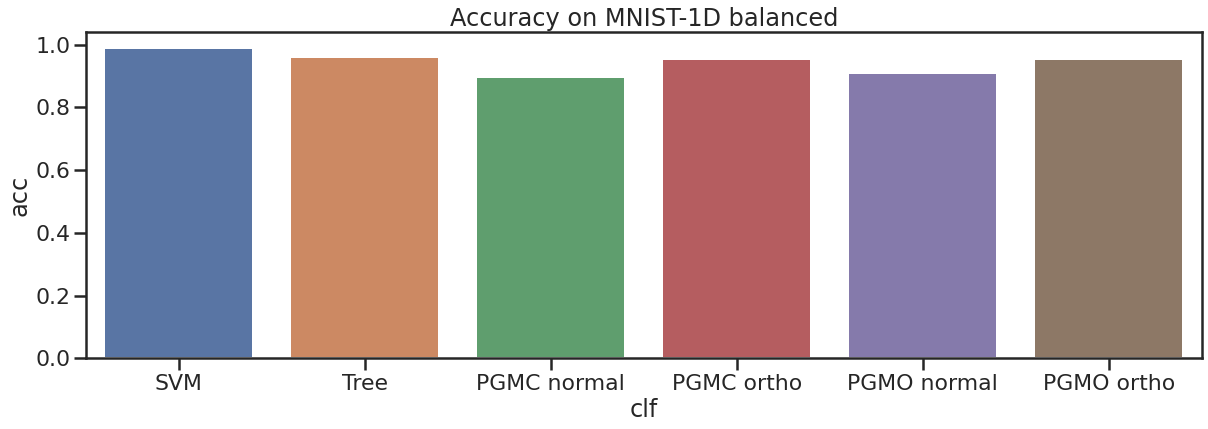

In [19]:
plt.figure(figsize=(20,6))
plt.title("Accuracy on MNIST-1D balanced")
sns.barplot(data=data[data.data=="MNIST-1D 0.5|0.5"],x="clf",y="acc")

<AxesSubplot:title={'center':'F1-score on MNIST imbalanced'}, xlabel='clf', ylabel='f1'>

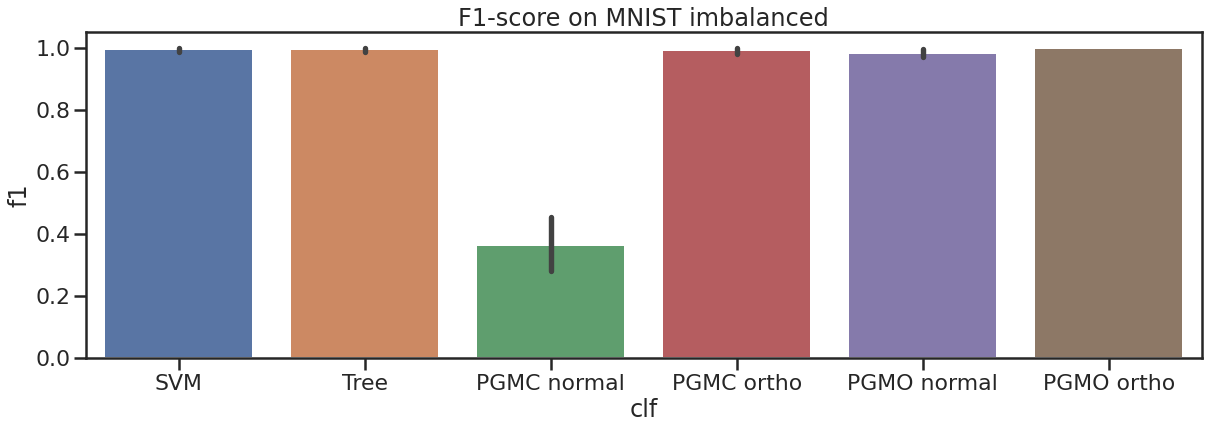

In [20]:
plt.figure(figsize=(20,6))
plt.title("F1-score on MNIST imbalanced")
sns.barplot(data=data[data.data=="MNIST 0.9|0.1"],x="clf",y="f1")

<AxesSubplot:title={'center':'F1-score on MNIST-1D imbalanced'}, xlabel='clf', ylabel='f1'>

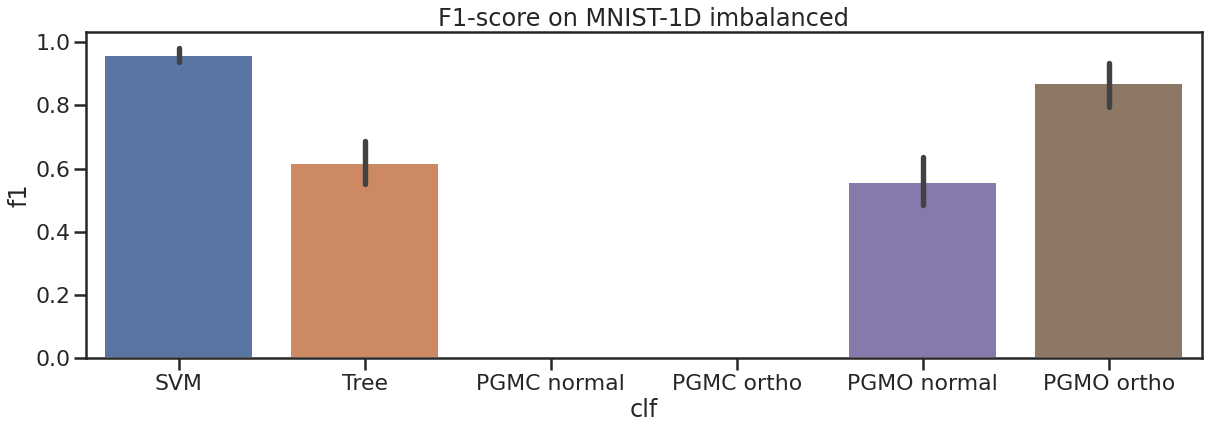

In [21]:
plt.figure(figsize=(20,6))
plt.title("F1-score on MNIST-1D imbalanced")
sns.barplot(data=data[data.data=="MNIST-1D 0.9|0.1"],x="clf",y="f1")